## ABOUT

- loading end of stage instead of best
- clearly overfitting
---
- Best MAE: 2.22  
- LB Score: 1.846

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.49
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v9'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = 392
bs = 16
num_workers = 6     # set to available cores

scale = 1           # number to divide y by to help normalize values
transform = 'spectogram'  # which time series to visual transformation to use

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following has been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
# set paths
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
img_path = path/f'train_images/{transform}'
save_path = path/'saved_models'
os.makedirs(save_path, exist_ok=True)

In [7]:
# load segment CSVs
#pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [8]:
#X_train.head()

In [9]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


min: 0.0063976571678
max: 16.103195567


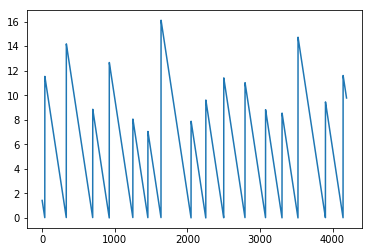

In [10]:
# graph y_train
print('min:', min(y_train['time_to_failure']))
print('max:', max(y_train['time_to_failure']))
plt.figure()
plt.plot(y_train)

## MODEL

In [11]:
# scale down the labels
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf / scale

In [12]:
gen_label(img_path/'seg_0.png')

1.4307971859

In [13]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [14]:
fake_label = 0.
#valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_rand_pct(valid_pct=0.20)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [15]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [16]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3356
valid:  838
test:   2624

TOTAL:  6818


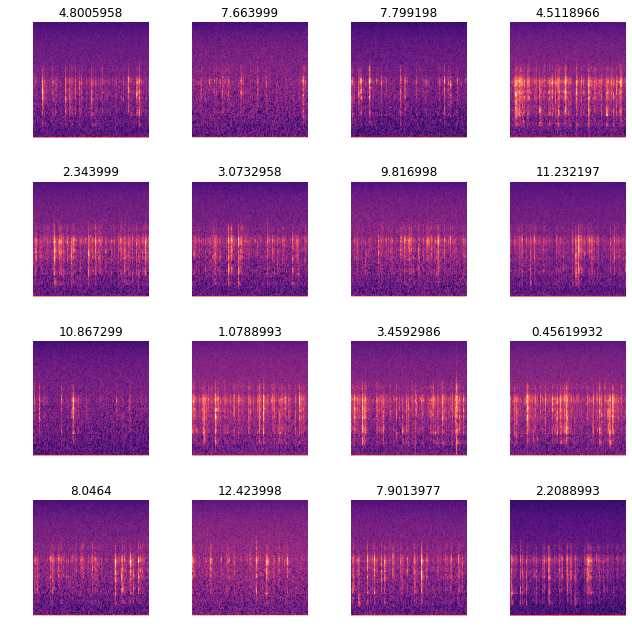

In [17]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [18]:
# define metrics
def mae_scaled(preds, targs):
    return mean_absolute_error(preds.view(-1)*scale, targs.view(-1)*scale)

def mse_scaled(preds, targs):
    return mean_squared_error(preds.view(-1)*scale, targs.view(-1)*scale)

In [19]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [20]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7
    elif arch == models.resnet50 and size == 224: return 2048*7*7
    elif arch == models.resnet50 and size == 392: return 2048*13*13

In [21]:
# define custom heads
small_head = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

small_head_sigmoid = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1),  nn.Sigmoid())

medium_head = nn.Sequential(
  nn.AvgPool2d(13, 13),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

big_head = nn.Sequential(
  nn.AvgPool2d(13, 13),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1))


big_head_sigmoid = nn.Sequential(
  nn.AvgPool2d(13, 13),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1),
  nn.Sigmoid())

In [22]:
# create learner
learn = cnn_learner(data, arch,
                    custom_head=big_head,
                    loss_func=l1_loss,
                    metrics=[mean_squared_error, mean_absolute_error, mse_scaled, mae_scaled])

In [23]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 196, 196]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 196, 196]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 196, 196]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 98, 98]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 98, 98]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 98, 98]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 98, 98]      36,864     False     
______________________________________________________________

## TRAIN

#### Helper functions

In [24]:
def plot_lr_find(learn):
    learn.lr_find()
    learn.recorder.plot()

In [25]:
def fit_one_cycle(learn, stage, n_epochs, max_lr):
    learn.fit_one_cycle(n_epochs, max_lr=max_lr, callbacks=[
        SaveModelCallback(learn,
                          monitor='mean_absolute_error',
                          mode='min',
                          every='improvement',
                          name=save_path/f'{version}-{stage}-best')])
    learn.recorder.plot_losses()
    learn.recorder.plot_lr(show_moms=True)

#### Stage 1.1

In [26]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


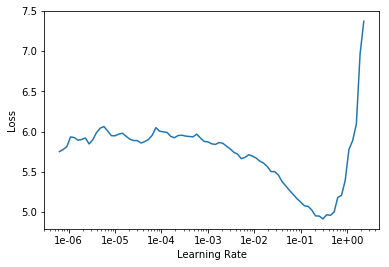

In [27]:
plot_lr_find(learn)

In [28]:
stage = 's1.1'
n_epochs = 15
max_lr = slice(1.1e-2)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,3.826761,2.550866,11.499649,2.550866,11.499649,2.550866,00:49
1,2.473689,2.255483,8.132958,2.255484,8.132958,2.255484,00:48
2,2.418947,2.282894,9.201617,2.282895,9.201617,2.282895,00:48
3,2.307048,2.151756,7.763314,2.151756,7.763314,2.151756,00:47
4,2.318471,2.380170,10.159475,2.380170,10.159475,2.380170,00:47
5,2.251398,2.133835,7.772270,2.133835,7.772270,2.133835,00:48
6,2.143773,2.293783,9.034607,2.293783,9.034607,2.293783,00:48
7,2.098063,2.231231,8.445727,2.231230,8.445727,2.231230,00:47
8,1.995550,2.176628,7.779012,2.176628,7.779012,2.176628,00:47
9,1.825192,2.382481,9.921040,2.382481,9.921040,2.382481,00:48


Better model found at epoch 0 with mean_absolute_error value: 2.550865650177002.
Better model found at epoch 1 with mean_absolute_error value: 2.255483627319336.
Better model found at epoch 3 with mean_absolute_error value: 2.1517562866210938.
Better model found at epoch 5 with mean_absolute_error value: 2.1338350772857666.


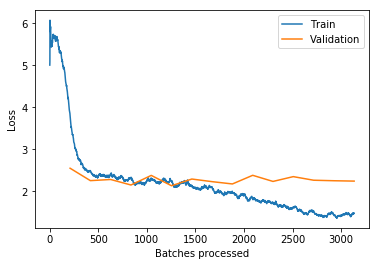

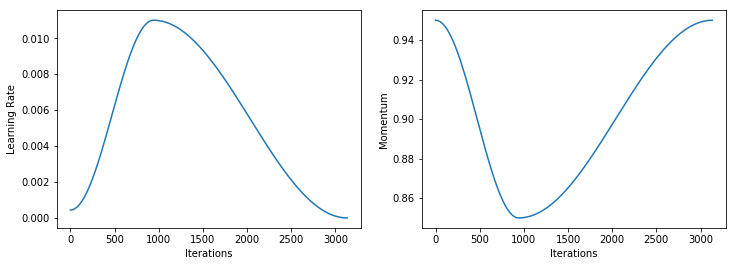

In [29]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

In [30]:
learn.save(save_path/f'{version}-s1.1')

#### Stage 1.2

In [31]:
learn.load(save_path/f'{version}-s1.1-best');

In [32]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


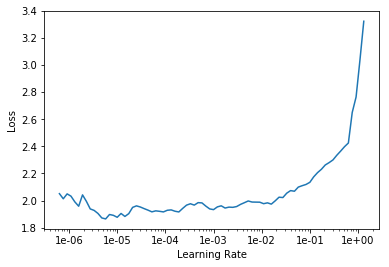

In [33]:
plot_lr_find(learn)

In [35]:
stage = 's1.2'
n_epochs = 15
max_lr = slice(1e-3)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,2.073722,2.183282,8.355583,2.183282,8.355583,2.183282,00:47
1,1.980620,2.159318,7.785175,2.159318,7.785175,2.159318,00:48
2,1.917131,2.174961,7.766174,2.174961,7.766174,2.174961,00:47
3,1.874901,2.182565,7.977322,2.182565,7.977322,2.182565,00:48
4,1.787462,2.211567,8.172899,2.211567,8.172899,2.211567,00:47
5,1.814877,2.229444,8.297771,2.229444,8.297771,2.229444,00:48
6,1.728241,2.250950,8.582843,2.250949,8.582843,2.250949,00:48
7,1.628681,2.265242,8.609156,2.265241,8.609156,2.265241,00:48
8,1.618331,2.252392,8.516318,2.252392,8.516318,2.252392,00:48
9,1.640003,2.267535,8.630081,2.267535,8.630081,2.267535,00:48


Better model found at epoch 0 with mean_absolute_error value: 2.1832823753356934.
Better model found at epoch 1 with mean_absolute_error value: 2.159318447113037.


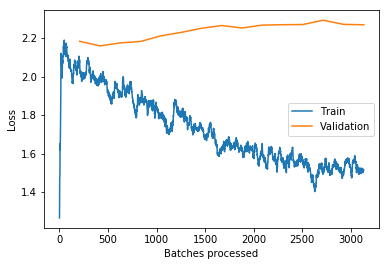

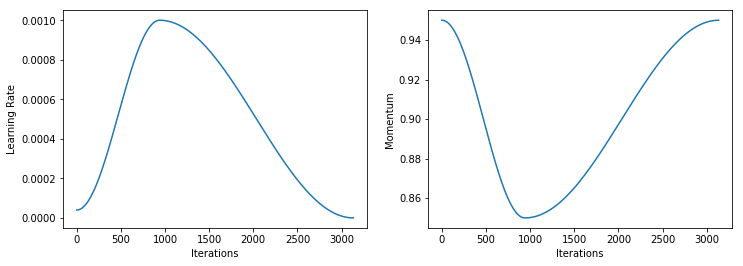

In [36]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

In [37]:
learn.save(save_path/f'{version}-s1.2')

#### Stage 2.1

In [43]:
learn.load(save_path/f'{version}-s1.2');

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


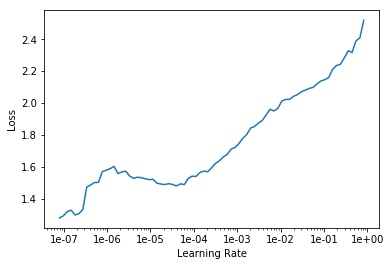

In [45]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [46]:
stage = 's2.1'
n_epochs = 15
max_lr = slice(3e-6, 3e-5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,1.555922,2.272686,8.583100,2.272686,8.583100,2.272686,01:06
1,1.556030,2.284350,8.935523,2.284350,8.935523,2.284350,01:06
2,1.457764,2.238065,8.321343,2.238064,8.321343,2.238064,01:06
3,1.524262,2.311102,8.924941,2.311102,8.924941,2.311102,01:05
4,1.386428,2.276708,8.330926,2.276708,8.330926,2.276708,01:06
5,1.363925,2.249693,8.341599,2.249693,8.341599,2.249693,01:06
6,1.381935,2.270437,8.651425,2.270437,8.651425,2.270437,01:06
7,1.373600,2.237710,8.090703,2.237710,8.090703,2.237710,01:06
8,1.314674,2.237862,8.199058,2.237862,8.199058,2.237862,01:06
9,1.258768,2.247413,8.261127,2.247413,8.261127,2.247413,01:06


Better model found at epoch 0 with mean_absolute_error value: 2.272686243057251.
Better model found at epoch 2 with mean_absolute_error value: 2.2380642890930176.
Better model found at epoch 7 with mean_absolute_error value: 2.237710475921631.
Better model found at epoch 11 with mean_absolute_error value: 2.2248432636260986.


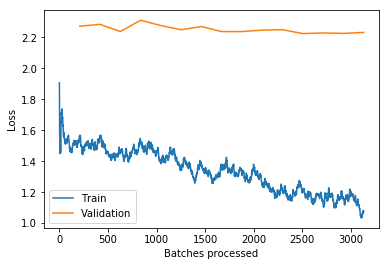

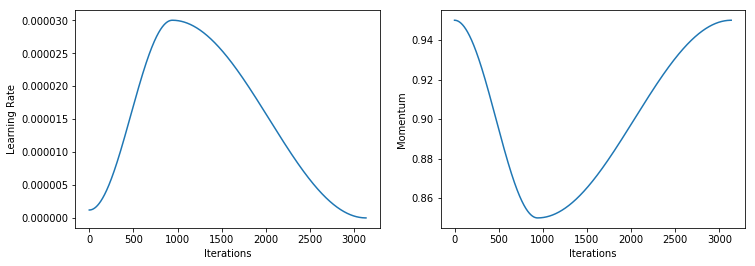

In [47]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

In [48]:
learn.save(save_path/f'{version}-s2.1')

#### Stage 2.2

In [49]:
learn.load(save_path/f'{version}-s2.1');

In [50]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


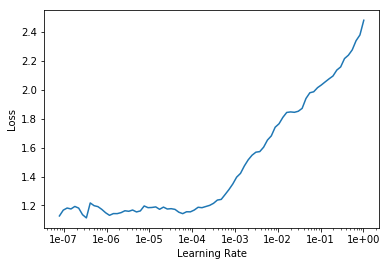

In [51]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [52]:
stage = 's2.2'
n_epochs = 15
max_lr = slice(5e-7, 5e-6)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,1.096191,2.225965,8.103217,2.225965,8.103217,2.225965,01:05
1,1.118741,2.226963,8.027851,2.226963,8.027851,2.226963,01:05
2,1.113330,2.227108,8.246047,2.227108,8.246047,2.227108,01:05
3,1.165964,2.223235,8.335769,2.223235,8.335769,2.223235,01:05
4,1.135317,2.242107,8.035455,2.242107,8.035455,2.242107,01:06
5,1.100394,2.226580,8.173376,2.226580,8.173376,2.226580,01:06
6,1.115701,2.222483,8.117976,2.222483,8.117976,2.222483,01:05
7,1.139837,2.226959,8.244006,2.226959,8.244006,2.226959,01:06
8,1.062053,2.228040,8.221879,2.228040,8.221879,2.228040,01:06
9,1.092332,2.227002,8.134376,2.227002,8.134376,2.227002,01:06


Better model found at epoch 0 with mean_absolute_error value: 2.2259654998779297.
Better model found at epoch 3 with mean_absolute_error value: 2.2232353687286377.
Better model found at epoch 6 with mean_absolute_error value: 2.2224831581115723.


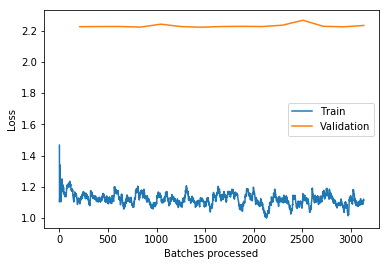

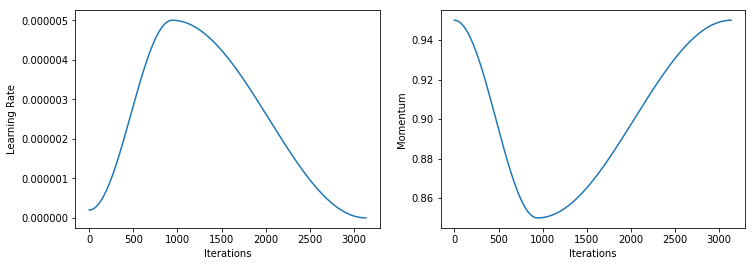

In [53]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

In [54]:
learn.save(save_path/f'{version}-s2.2')

## RESULTS

In [55]:
learn.load(save_path/f'{version}-s2.2');

In [56]:
# plot histograms of results
def plot_results(dataset):
    preds, targs = learn.get_preds(ds_type=dataset)
    preds = preds * scale
    targs = targs * scale
    print('min/max pred: ', min(preds).item(), max(preds).item())
    print('min/max targ: ', min(targs).item(), max(targs).item())
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('TTF'); ax1.set_ylabel('preds')
    ax2.plot(preds); ax2.set_xlabel('segment')
    ax3.hist(targs, bins=50); ax3.set_xlabel('TTF'); ax3.set_ylabel('targs')
    ax4.plot(targs); ax4.set_xlabel('segment')

#### Training Set

min/max pred:  -0.030886292457580566 13.524338722229004
min/max targ:  0.006397657096385956 16.103195190429688


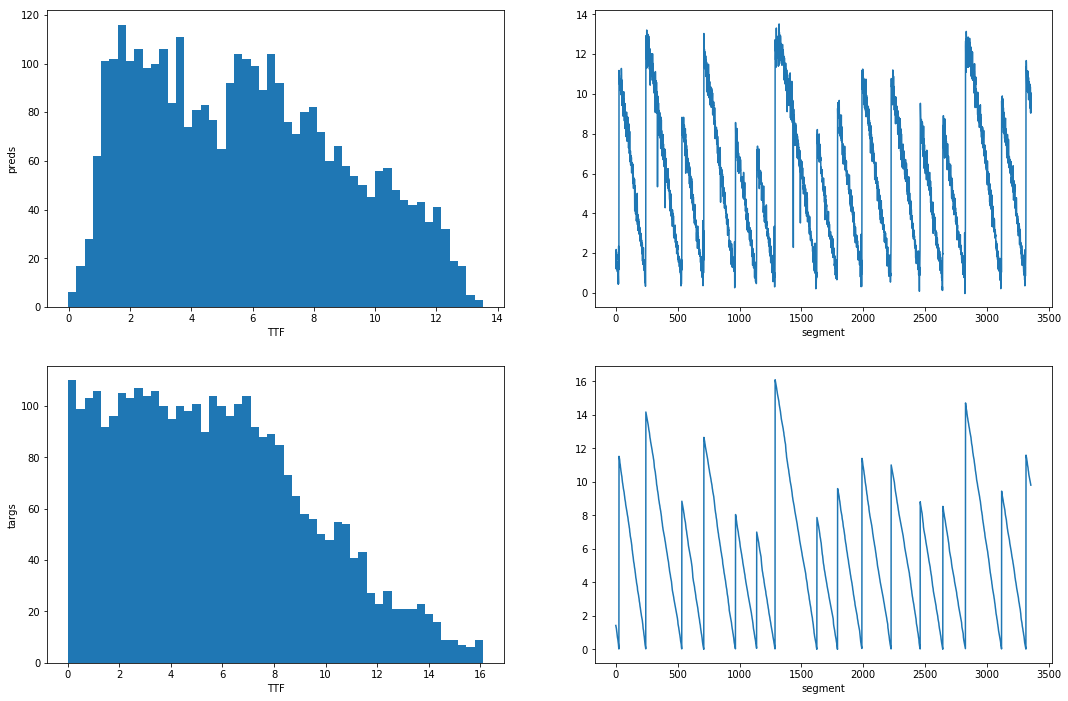

In [67]:
plot_results(DatasetType.Fix)

#### Validation Set

min/max pred:  0.644916296005249 11.270106315612793
min/max targ:  0.0072983005084097385 15.634998321533203


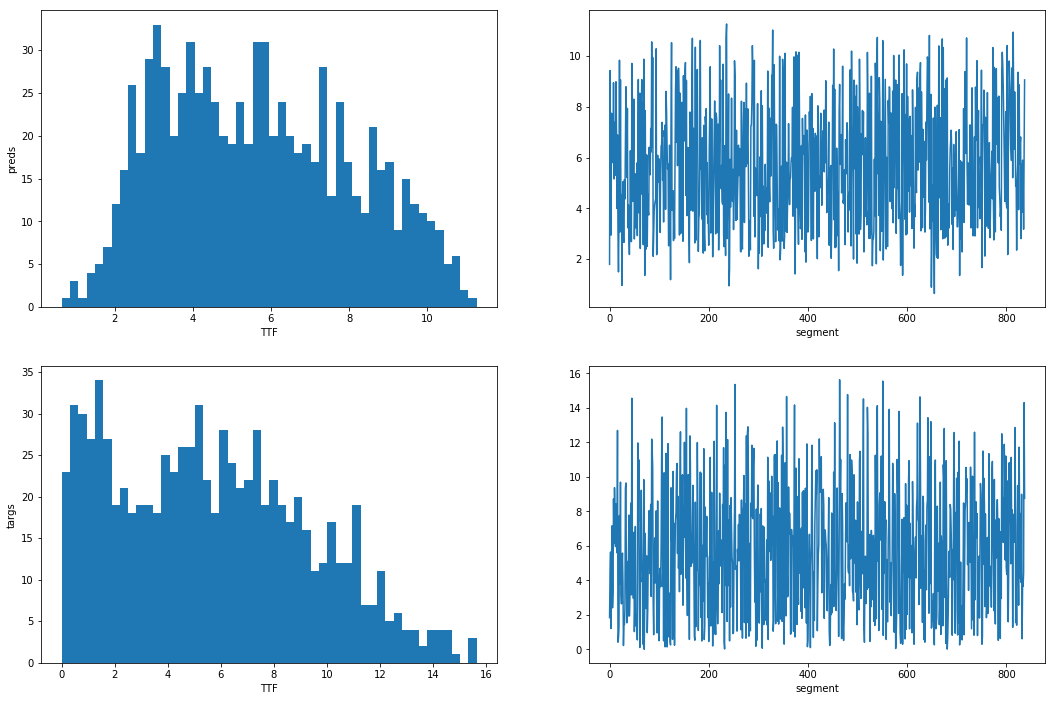

In [58]:
plot_results(DatasetType.Valid)

#### Test Set

min/max pred:  -0.22786372900009155 11.9078950881958
min/max targ:  0.0 0.0


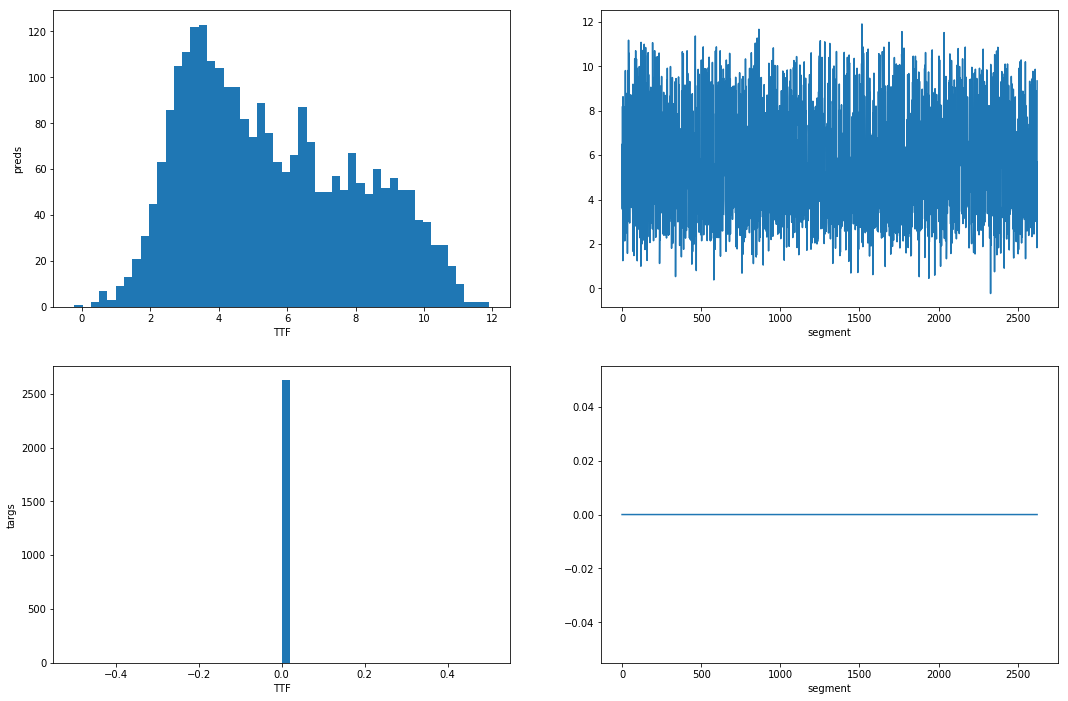

In [59]:
plot_results(DatasetType.Test)

## SUBMISSION

In [60]:
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [61]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [62]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() * scale for i in range(len(test_preds))]

In [63]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,6.480219
seg_0012b5,3.569469
seg_00184e,3.577997
seg_003339,8.196292
seg_0042cc,5.534825


In [64]:
submission_file = path/f'{version}-submission.csv'
submission.to_csv(submission_file)

In [65]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f $submission_file -m "Message"

100%|██████████████████████████████████████| 74.8k/74.8k [00:06<00:00, 11.2kB/s]
Successfully submitted to LANL Earthquake Prediction